# One-dimensional regression

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/AbstractGPs.jl/blob/master/examples/regression-1d/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/AbstractGPs.jl/dev/examples/regression-1d/).*

## Setup

Loading the necessary packages and setting seed.

In [1]:
using AbstractGPs
using Distributions
using StatsFuns

using Plots
default(; legend=:outertopright, size=(700, 400))

using Random
Random.seed!(42)

MersenneTwister(42)

Load toy regression
[dataset](https://github.com/GPflow/docs/blob/master/doc/source/notebooks/basics/data/regression_1D.csv)
taken from GPFlow examples.

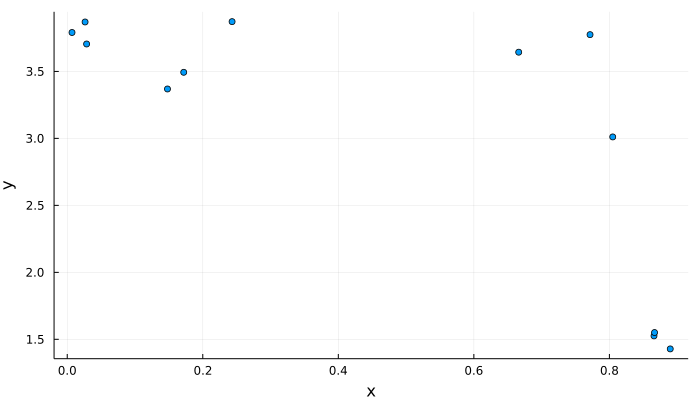

In [2]:
x = [
    0.8658165855998895,
    0.6661700880180962,
    0.8049218148148531,
    0.7714303440386239,
    0.14790478354654835,
    0.8666105548197428,
    0.007044577166530286,
    0.026331737288148638,
    0.17188596617099916,
    0.8897812990554013,
    0.24323574561119998,
    0.028590102134105955,
]
y = [
    1.5255314337144372,
    3.6434202968230003,
    3.010885733911661,
    3.774442382979625,
    3.3687639483798324,
    1.5506452040608503,
    3.790447985799683,
    3.8689707574953,
    3.4933565751758713,
    1.4284538820635841,
    3.8715350915692364,
    3.7045949061144983,
]
scatter(x, y; xlabel="x", ylabel="y", legend=false)

We split the observations into train and test data.

In [3]:
x_train = x[1:8]
y_train = y[1:8]
x_test = x[9:end]
y_test = y[9:end]

4-element Vector{Float64}:
 3.4933565751758713
 1.4284538820635841
 3.8715350915692364
 3.7045949061144983

We instantiate a Gaussian process with a Matern kernel. The kernel has
fixed variance and length scale parameters of default value 1.

In [4]:
f = GP(Matern52Kernel())

AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.Matern52Kernel{Distances.Euclidean}}(AbstractGPs.ZeroMean{Float64}(), Matern 5/2 Kernel (metric = Distances.Euclidean(0.0)))

We create a finite dimensional projection at the inputs of the training dataset
observed under Gaussian noise with standard deviation $\sigma = 0.1$, and compute the
log-likelihood of the outputs of the training dataset.

In [5]:
fx = f(x_train, 0.1)
logpdf(fx, y_train)

-25.53057444906228

We compute the posterior Gaussian process given the training data, and calculate the
log-likelihood of the test dataset.

In [6]:
p_fx = posterior(fx, y_train)
logpdf(p_fx(x_test), y_test)

-232.51565975767468

We plot the posterior Gaussian process (its mean and a ribbon of 2 standard deviations
around it) on a grid along with the observations.

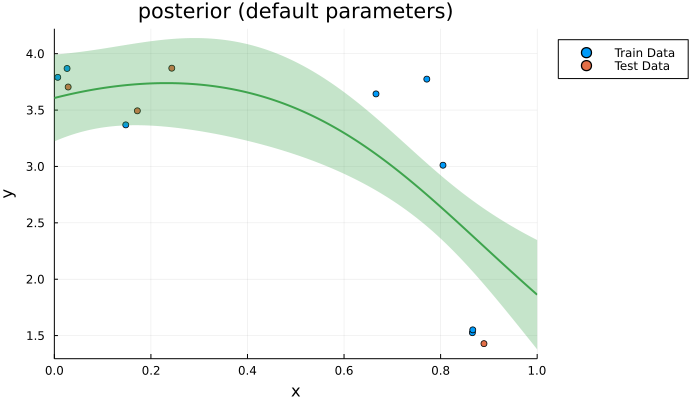

In [7]:
scatter(
    x_train,
    y_train;
    xlim=(0, 1),
    xlabel="x",
    ylabel="y",
    title="posterior (default parameters)",
    label="Train Data",
)
scatter!(x_test, y_test; label="Test Data")
plot!(0:0.001:1, p_fx; label=false, ribbon_scale=2)

## Markov Chain Monte Carlo

Previously we computed the log likelihood of the untuned kernel parameters of the GP.
We now also perform approximate inference over said kernel parameters using different
Markov chain Monte Carlo (MCMC) methods. I.e., we approximate the posterior distribution
of the kernel parameters with samples from a Markov chain.

We define a function which returns the log-likelihood of the data for different variance
and inverse lengthscale parameters of the Matern kernel. We ensure that these parameters are
positive with the softplus function
$$
f(x) = \log (1 + \exp x).
$$

In [8]:
function gp_loglikelihood(x, y)
    function loglikelihood(params)
        kernel =
            softplus(params[1]) * (Matern52Kernel() ∘ ScaleTransform(softplus(params[2])))
        f = GP(kernel)
        fx = f(x, 0.1)
        return logpdf(fx, y)
    end
    return loglikelihood
end

const loglik_train = gp_loglikelihood(x_train, y_train)

(::Main.##280.var"#loglikelihood#1"{Vector{Float64}, Vector{Float64}}) (generic function with 1 method)

We define a Gaussian prior for the joint distribution of the two transformed kernel
parameters. We assume that both parameters are independent with mean 0 and variance 1.

In [9]:
logprior(params) = logpdf(MvNormal(2, 1), params)

logprior (generic function with 1 method)

### Hamiltonian Monte Carlo

We start with a Hamiltonian Monte Carlo (HMC) sampler. More precisely, we use the
[No-U-Turn sampler (NUTS)](http://www.jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf),
which is provided by the Julia packages
[AdvancedHMC.jl](https://github.com/TuringLang/AdvancedHMC.jl/) and
[DynamicHMC.jl](https://github.com/tpapp/DynamicHMC.jl/).

#### AdvancedHMC

We start with performing inference with AdvancedHMC.

In [10]:
using AdvancedHMC
using ForwardDiff

Set the number of samples to draw and warmup iterations.

In [11]:
n_samples = 2_000
n_adapts = 1_000

1000

Define a Hamiltonian system of the log joint probability.

In [12]:
logjoint_train(params) = loglik_train(params) + logprior(params)
metric = DiagEuclideanMetric(2)
hamiltonian = Hamiltonian(metric, logjoint_train, ForwardDiff)

Hamiltonian(metric=DiagEuclideanMetric([1.0, 1.0]))

Define a leapfrog solver, with initial step size chosen heuristically.

In [13]:
initial_params = rand(2)
initial_ϵ = find_good_stepsize(hamiltonian, initial_params)
integrator = Leapfrog(initial_ϵ)

Leapfrog(ϵ=1.6)

Define an HMC sampler, with the following components:
- multinomial sampling scheme,
- generalised No-U-Turn criteria, and
- windowed adaption for step-size and diagonal mass matrix

In [14]:
proposal = NUTS{MultinomialTS,GeneralisedNoUTurn}(integrator)
adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))

StanHMCAdaptor(
    pc=WelfordVar,
    ssa=NesterovDualAveraging(γ=0.05, t_0=10.0, κ=0.75, δ=0.8, state.ϵ=1.6),
    init_buffer=75, term_buffer=50, window_size=25,
    state=window(0, 0), window_splits()
)

We draw samples from the posterior distribution of kernel parameters. These samples
are in the unconstrained space $\mathbb{R}^2$.

In [15]:
samples, _ = sample(
    hamiltonian, proposal, initial_params, n_samples, adaptor, n_adapts; progress=false
)

┌ Info: Finished 1000 adapation steps
│   adaptor =
│    StanHMCAdaptor(
│        pc=WelfordVar,
│        ssa=NesterovDualAveraging(γ=0.05, t_0=10.0, κ=0.75, δ=0.8, state.ϵ=0.8783021314108809),
│        init_buffer=75, term_buffer=50, window_size=25,
│        state=window(76, 950), window_splits(100, 150, 250, 450, 950)
│    )
│   τ.integrator = Leapfrog(ϵ=0.878)
└   h.metric = DiagEuclideanMetric([0.4629350832008615, 0.5149 ...])
┌ Info: Finished 2000 sampling steps for 1 chains in 0.39634642 (s)
│   h = Hamiltonian(metric=DiagEuclideanMetric([0.4629350832008615, 0.5149 ...]))
│   τ = NUTS{MultinomialTS,Generalised}(integrator=Leapfrog(ϵ=0.878), max_depth=10), Δ_max=1000.0)
│   EBFMI_est = 1.1378159434617516
└   average_acceptance_rate = 0.8449975678302384


([[0.5331830160438613, 0.4540291355871424], [0.5331830160438613, 0.4540291355871424], [0.7303921746125681, 0.4252419319229579], [1.7188348863056717, 0.5793889557335234], [1.7767869516235208, 0.3292702458868477], [2.0762288443168857, 1.3124446464873132], [2.0762288443168857, 1.3124446464873132], [2.497101532463215, 2.5233846482027964], [2.543532492047188, 2.6987074737517838], [2.5059001207872296, 1.429954034277459]  …  [2.5267897248689573, 3.4184290773681463], [2.561459457066112, 1.9876459460378557], [2.2735243487924617, 2.5336088536244126], [2.1023824481442137, 2.8363557394459527], [0.754146354595449, 0.9418066296877088], [3.440002924514747, 2.5032162214688625], [2.3219994379281816, 2.0955514761611096], [1.9127415096121274, 2.2641614082431842], [2.1986320780930693, 1.5340072640435123], [1.5273713821365966, 4.017400940664742]], NamedTuple[(n_steps = 1, is_accept = true, acceptance_rate = 1.4834340066548196e-5, log_density = -27.89670770936437, hamiltonian_energy = 28.018693836228163, ha

We transform the samples back to the constrained space and compute the mean of both
parameters:

In [16]:
samples_constrained = [map(softplus, p) for p in samples]
mean_samples = mean(samples_constrained)

2-element Vector{Float64}:
 2.320801064247753
 2.262777439987716

We plot a histogram of the samples for the two parameters.
The vertical line in each graph indicates the mean of the samples.

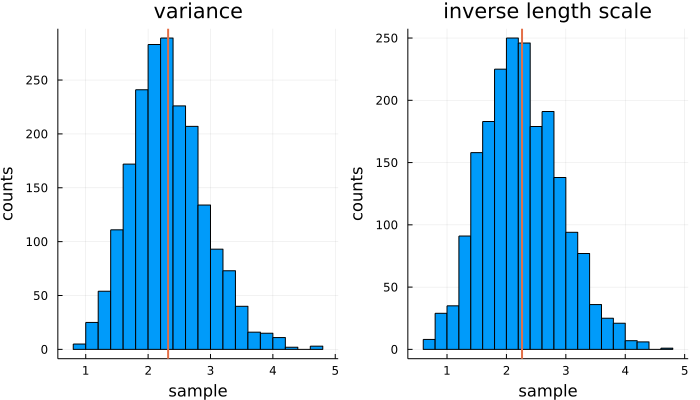

In [17]:
histogram(
    reduce(hcat, samples_constrained)';
    xlabel="sample",
    ylabel="counts",
    layout=2,
    title=["variance" "inverse length scale"],
    legend=false,
)
vline!(mean_samples'; linewidth=2)

We approximate the log-likelihood of the test data using the posterior Gaussian processes
for kernels with the sampled kernel parameters. We can observe that there is a significant
improvement over the log-likelihood of the test data with respect to the posterior
Gaussian process with default kernel parameters of value 1.

In [18]:
function gp_posterior(x, y, p)
    kernel = softplus(p[1]) * (Matern52Kernel() ∘ ScaleTransform(softplus(p[2])))
    f = GP(kernel)
    return posterior(f(x, 0.1), y)
end

mean(logpdf(gp_posterior(x_train, y_train, p)(x_test), y_test) for p in samples)

-11.204446271486626

We sample 5 functions from each posterior GP given by the final 100 samples of kernel
parameters.

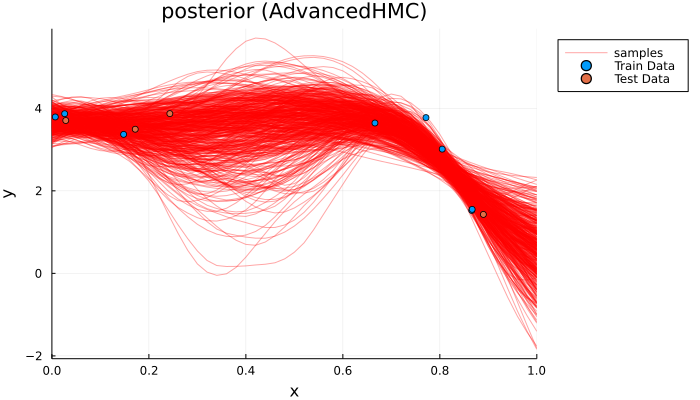

In [19]:
plt = plot(; xlim=(0, 1), xlabel="x", ylabel="y", title="posterior (AdvancedHMC)")
for (i, p) in enumerate(samples[(end - 100):end])
    sampleplot!(
        plt,
        0:0.02:1,
        gp_posterior(x_train, y_train, p);
        samples=5,
        seriescolor="red",
        label=(i == 1 ? "samples" : nothing),
    )
end
scatter!(plt, x_train, y_train; label="Train Data", markercolor=1)
scatter!(plt, x_test, y_test; label="Test Data", markercolor=2)
plt

#### DynamicHMC

We repeat the inference with DynamicHMC. DynamicHMC requires us to
implement the LogDensityProblems interface for `loglik_train`.

In [20]:
using DynamicHMC
using LogDensityProblems

# Log joint density
function LogDensityProblems.logdensity(ℓ::typeof(loglik_train), params)
    return ℓ(params) + logprior(params)
end

# The parameter space is two-dimensional
LogDensityProblems.dimension(::typeof(loglik_train)) = 2

# `loglik_train` does not allow to evaluate derivatives of
# the log-likelihood function
function LogDensityProblems.capabilities(::Type{<:typeof(loglik_train)})
    return LogDensityProblems.LogDensityOrder{0}()
end

Now we can draw samples from the posterior distribution of kernel parameters with
DynamicHMC. Again we use [ForwardDiff.jl](https://github.com/JuliaDiff/ForwardDiff.jl)
to compute the derivatives of the log joint density with automatic differentiation.

In [21]:
samples =
    mcmc_with_warmup(
        Random.GLOBAL_RNG,
        ADgradient(:ForwardDiff, loglik_train),
        n_samples;
        reporter=NoProgressReport(),
    ).chain

2000-element Vector{Vector{Float64}}:
 [3.1517972574912374, 3.1770375312931267]
 [3.0134530122001677, 2.3695348918318824]
 [3.0514419854582333, 2.326303325335356]
 [1.3493863106989874, 1.8303808182042063]
 [0.7788001886555601, 1.8581945000196323]
 [2.4016698606550184, 1.8134406821526252]
 [2.7549993745792984, 2.1337766892169134]
 [1.307968671372088, 3.0160769813792188]
 [3.1360295612598392, 1.978648871174682]
 [2.7667978904567674, 1.7265089526782276]
 ⋮
 [2.9799654197976313, 2.624362092223539]
 [1.0903630713301882, 1.4051572601500002]
 [1.7557205400420197, 2.3066382053891346]
 [2.470676318523326, 1.8981906486954108]
 [2.369820426416629, 2.781602222229255]
 [2.9128332052840804, 1.8400708799727896]
 [1.8050711241300843, 3.340784141237192]
 [1.645590672912958, 3.821823968202606]
 [1.6076753985390004, 3.7893139712825237]

We transform the samples back to the constrained space and compute the mean of both
parameters:

In [22]:
samples_constrained = [map(softplus, p) for p in samples]
mean_samples = mean(samples_constrained)

2-element Vector{Float64}:
 2.31522466420798
 2.2627046116441707

We plot a histogram of the samples for the two parameters.
The vertical line in each graph indicates the mean of the samples.

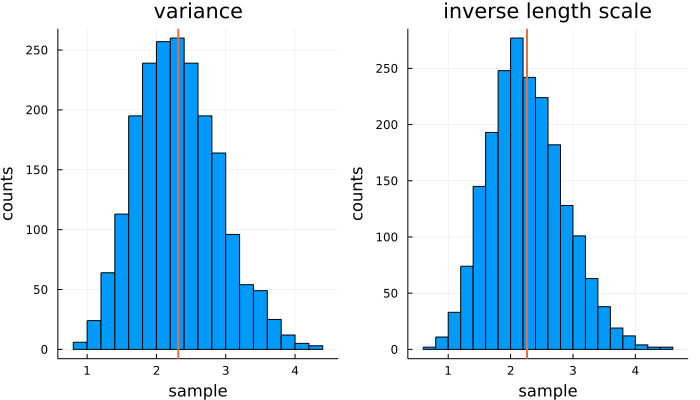

In [23]:
histogram(
    reduce(hcat, samples_constrained)';
    xlabel="sample",
    ylabel="counts",
    layout=2,
    title=["variance" "inverse length scale"],
    legend=false,
)
vline!(mean_samples'; linewidth=2)

Again we can observe that there is a significant improvement over the log-likelihood
of the test data with respect to the posterior Gaussian process with default kernel
parameters.

In [24]:
mean(logpdf(gp_posterior(x_train, y_train, p)(x_test), y_test) for p in samples)

-7.449598088103853

We sample a function from the posterior GP for the final 100 samples of kernel
parameters.

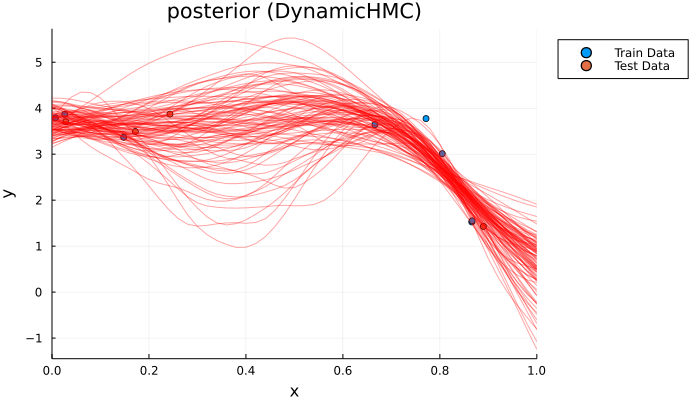

In [25]:
plt = plot(; xlim=(0, 1), xlabel="x", ylabel="y", title="posterior (DynamicHMC)")
scatter!(plt, x_train, y_train; label="Train Data")
scatter!(plt, x_test, y_test; label="Test Data")
for p in samples[(end - 100):end]
    sampleplot!(plt, 0:0.02:1, gp_posterior(x_train, y_train, p); seriescolor="red")
end
plt

### Elliptical slice sampling

Instead of HMC, we use
[elliptical slice sampling](http://proceedings.mlr.press/v9/murray10a/murray10a.pdf)
which is provided by the Julia package
[EllipticalSliceSampling.jl](https://github.com/TuringLang/EllipticalSliceSampling.jl/).

In [26]:
using EllipticalSliceSampling

We draw 2000 samples from the posterior distribution of kernel parameters.

In [27]:
samples = sample(ESSModel(
    MvNormal(2, 1), # Gaussian prior
    loglik_train,
), ESS(), n_samples; progress=false)

2000-element Vector{Vector{Float64}}:
 [0.14902076106319687, 1.8447751100420657]
 [0.3993923430179096, 1.3473133289827472]
 [0.5414676902202902, 1.2835168248529847]
 [0.5645277329280608, 1.2420460509700988]
 [1.5272169098337347, 1.3132892733379906]
 [1.1582586372998676, 1.6335796238848554]
 [0.8428541597523433, 2.4100883362395074]
 [0.9821563822861374, 3.1755870259357613]
 [0.9684009920231265, 3.27362145190543]
 [1.351795182840731, 3.494021905923174]
 ⋮
 [3.1678168494716674, 2.481256648857004]
 [2.9088234342799577, 2.833116863414303]
 [2.8621065356895374, 2.8056332661368866]
 [2.5738990898788305, 3.0315578883293157]
 [2.6059002358815477, 3.016169087101304]
 [2.7232133653712274, 2.8239402785971994]
 [2.750034619580062, 2.860022380489441]
 [2.734602062540727, 3.02687944916989]
 [2.5387914379146537, 2.856647588013183]

We transform the samples back to the constrained space and compute the mean of both
parameters:

In [28]:
samples_constrained = [map(softplus, p) for p in samples]
mean_samples = mean(samples_constrained)

2-element Vector{Float64}:
 2.37178314201933
 2.3049676366916776

We plot a histogram of the samples for the two parameters.
The vertical line in each graph indicates the mean of the samples.

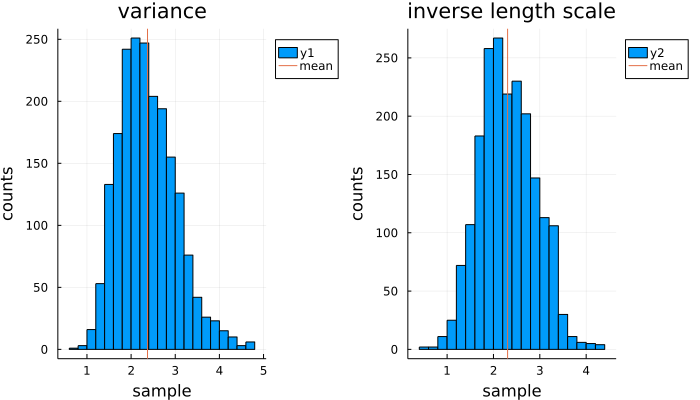

In [29]:
histogram(
    reduce(hcat, samples_constrained)';
    xlabel="sample",
    ylabel="counts",
    layout=2,
    title=["variance" "inverse length scale"],
)
vline!(mean_samples'; layout=2, labels="mean")

Again we can observe that there is a significant improvement over the log-likelihood
of the test data with respect to the posterior Gaussian process with default kernel
parameters.

In [30]:
mean(logpdf(gp_posterior(x_train, y_train, p)(x_test), y_test) for p in samples)

-8.245025486317127

We sample a function from the posterior GP for the final 100 samples of kernel
parameters.

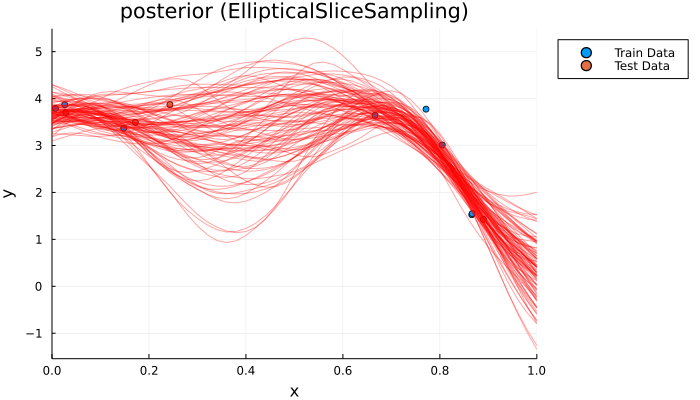

In [31]:
plt = plot(;
    xlim=(0, 1), xlabel="x", ylabel="y", title="posterior (EllipticalSliceSampling)"
)
scatter!(plt, x_train, y_train; label="Train Data")
scatter!(plt, x_test, y_test; label="Test Data")
for p in samples[(end - 100):end]
    sampleplot!(plt, 0:0.02:1, gp_posterior(x_train, y_train, p); seriescolor="red")
end
plt

## Variational Inference

Sanity check for the Evidence Lower BOund (ELBO) implemented according to
M. K. Titsias's _Variational learning of inducing variables in sparse Gaussian processes_.

In [32]:
elbo(VFE(f(rand(5))), fx, y_train)

-25.672858860550487

We use the LBFGS algorithm to maximize the given ELBO. It is provided by the Julia
package [Optim.jl](https://github.com/JuliaNLSolvers/Optim.jl).

In [33]:
using Optim

We define a function which returns the negative ELBO for different variance and inverse
lengthscale parameters of the Matern kernel and different pseudo-points. We ensure that
the kernel parameters are positive with the softplus function
$$
f(x) = \log (1 + \exp x),
$$
and that the pseudo-points are in the unit interval $[0,1]$ with the logistic function
$$
f(x) = \frac{1}{1 + \exp{(-x)}}.
$$

In [34]:
jitter = 1e-6  # "observing" the latent process with some (small) amount of jitter improves numerical stability

function objective_function(x, y)
    function negative_elbo(params)
        kernel =
            softplus(params[1]) * (Matern52Kernel() ∘ ScaleTransform(softplus(params[2])))
        f = GP(kernel)
        fx = f(x, 0.1)
        z = logistic.(params[3:end])
        approx = VFE(f(z, jitter))
        return -elbo(approx, fx, y)
    end
    return negative_elbo
end

objective_function (generic function with 1 method)

We randomly initialize the kernel parameters and 5 pseudo points, and minimize the
negative ELBO with the LBFGS algorithm and obtain the following optimal parameters:

In [35]:
x0 = rand(7)
opt = optimize(objective_function(x_train, y_train), x0, LBFGS())

 * Status: success

 * Candidate solution
    Final objective value:     1.086925e+01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 8.27e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.87e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.68e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.23e-15 ≰ 0.0e+00
    |g(x)|                 = 9.39e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    31
    f(x) calls:    75
    ∇f(x) calls:   75


In [36]:
opt.minimizer

7-element Vector{Float64}:
  8.379380099258691
  3.9327375493482046
 -4.133679974767163
  0.6917102799348074
 -1.758326768085746
  1.2763097379723627
  1.847957118444756

The optimized value of the variance is

In [37]:
softplus(opt.minimizer[1])

8.379609625116554

and of the inverse lengthscale is

In [38]:
softplus(opt.minimizer[2])

3.9521381061871685

We compute the log-likelihood of the test data for the resulting approximate
posterior. We can observe that there is a significant improvement over the
log-likelihood with the default kernel parameters of value 1.

In [39]:
opt_kernel =
    softplus(opt.minimizer[1]) *
    (Matern52Kernel() ∘ ScaleTransform(softplus(opt.minimizer[2])))
opt_f = GP(opt_kernel)
opt_fx = opt_f(x_train, 0.1)
ap = posterior(VFE(opt_f(logistic.(opt.minimizer[3:end]), jitter)), opt_fx, y_train)
logpdf(ap(x_test), y_test)

-1.0522111749540446

We visualize the approximate posterior with optimized parameters.

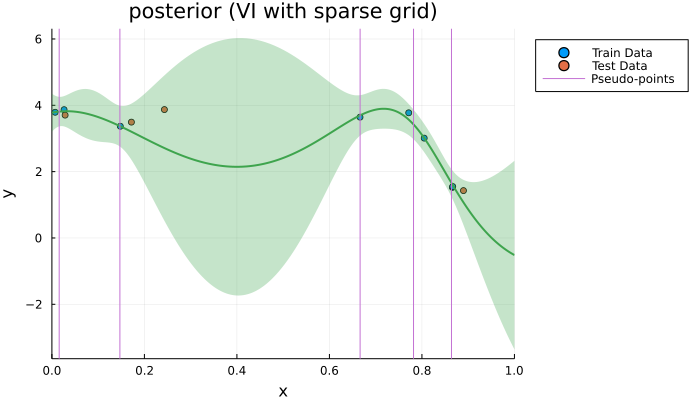

In [40]:
scatter(
    x_train,
    y_train;
    xlim=(0, 1),
    xlabel="x",
    ylabel="y",
    title="posterior (VI with sparse grid)",
    label="Train Data",
)
scatter!(x_test, y_test; label="Test Data")
plot!(0:0.001:1, ap; label=false, ribbon_scale=2)
vline!(logistic.(opt.minimizer[3:end]); label="Pseudo-points")

## Exact Gaussian Process Inference

Here we use Type-II MLE to train the hyperparameters of the Gaussian process.
This means that our loss function is the negative log marginal likelihood.

We re-calculate the log-likelihood of the test dataset with the
default kernel parameters of value 1 for the sake of comparison.

In [41]:
logpdf(p_fx(x_test), y_test)

-232.51565975767468

We define a function which returns the negative log marginal
likelihood for different variance and inverse lengthscale parameters
of the Matern kernel and different pseudo-points. We ensure that the
kernel parameters are positive with the softplus function
``f(x) = \log (1 + \exp x)``.

In [42]:
function loss_function(x, y)
    function negativelogmarginallikelihood(params)
        kernel =
            softplus(params[1]) * (Matern52Kernel() ∘ ScaleTransform(softplus(params[2])))
        f = GP(kernel)
        fx = f(x, 0.1)
        return -logpdf(fx, y)
    end
    return negativelogmarginallikelihood
end

loss_function (generic function with 1 method)

We randomly initialize the kernel parameters, and minimize the
negative log marginal likelihood with the LBFGS algorithm
and obtain the following optimal parameters:

In [43]:
θ0 = randn(2)
opt = Optim.optimize(loss_function(x_train, y_train), θ0, LBFGS())

 * Status: success

 * Candidate solution
    Final objective value:     1.085252e+01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 7.66e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 9.14e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.04e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.54e-14 ≰ 0.0e+00
    |g(x)|                 = 2.25e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    8
    f(x) calls:    23
    ∇f(x) calls:   23


In [44]:
opt.minimizer

2-element Vector{Float64}:
 8.38552052998622
 3.9687942190816896

The optimized value of the variance is

In [45]:
softplus(opt.minimizer[1])

8.385748650934984

and of the inverse lengthscale is

In [46]:
softplus(opt.minimizer[2])

3.9875141075711538

We compute the log-likelihood of the test data for the resulting optimized
posterior. We can observe that there is a significant improvement over the
log-likelihood with the default kernel parameters of value 1.

In [47]:
opt_kernel =
    softplus(opt.minimizer[1]) *
    (Matern52Kernel() ∘ ScaleTransform(softplus(opt.minimizer[2])))

opt_f = GP(opt_kernel)
opt_fx = opt_f(x_train, 0.1)
opt_p_fx = posterior(opt_fx, y_train)
logpdf(opt_p_fx(x_test), y_test)

-1.0849767537352928

We visualize the posterior with optimized parameters.

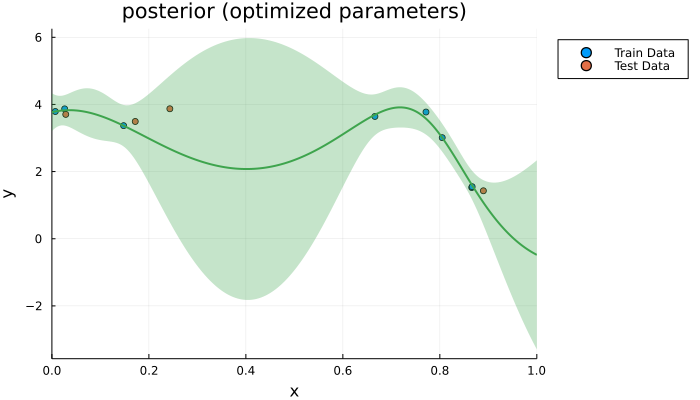

In [48]:
scatter(
    x_train,
    y_train;
    xlim=(0, 1),
    xlabel="x",
    ylabel="y",
    title="posterior (optimized parameters)",
    label="Train Data",
)
scatter!(x_test, y_test; label="Test Data")
plot!(0:0.001:1, opt_p_fx; label=false, ribbon_scale=2)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*